# **Explorando el mundo a nanoescala: simulaciones en Acción**

---

#**0 Instalamos dependencias necesarias**.

In [3]:
#@title Descargar instalador
#@markdown Esperar que cargue.
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()


⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [4]:
%%capture
#@title Instalar LAMMPS
#@markdown Tomará algunos minutos. ;-)
# install dependencies

!conda --version
!which conda
!conda install -c conda-forge -y requests lammps gxx_linux-64 -y
!pip install git+https://github.com/chdre/lammps-logfile-reader

In [1]:
#@title Carga de modulos
#@markdown  Esperar unos segundos. (seguro salta un error, volver a ejecutar esta linea)
# install dependencies

#Cargar lammps
from lammps import IPyLammps
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lammps_logfile_reader import ReadLog
import requests
import IPython.display as Disp
from IPython.display import YouTubeVideo


In [2]:
#@title Carga de visualizador
#@markdown    Esperar unos segundos. (seguro salta un error, volver a ejecutar esta linea)
# install dependencies


#cargar visualizador

from IPython.display import display, HTML
display(HTML("<style>.container { width:1400 !important; }</style>"))

#construir un dataframe  mass_df
mass_df = pd.DataFrame(columns=['type', 'mass','element'])
# asignar al 'type' = 1 la 'mass' = 1 y element = H
mass_df.loc[0] = [1, 1, 'X']

#source: https://gitlab.com/doublylinkedlist/20210505_demo/-/raw/master/util.py

import io
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re

mass2element = {
    16: 'O',
    12: "C",
    1: "H",
    14: 'N',
    -999: 'X',
}
element2color = {
    "O": 'rgba(255, 0, 0, 1.0)',
    "C": 'rgba(105, 105, 105, 1.0)',
    "H": 'rgba(255, 255, 255, 1.0)',
    'N': 'rgba(255, 0, 255, 1.0)',
    "X": 'rgba(138, 43, 226, 1.0)',
}
element2size = {
    "O": 74.,
    'N': 74.,
    "C": 77.,
    "H": 46.,
    "X": 90.,
}


def read_xyz_traj(filename='traj.xyz'):
    colnames = ["at", "x", "y", "z"]
    with open(filename, 'r') as myfile:
        xyz = myfile.read()
    frame_natoms = []
    frame_nsteps = []
    frame_xyzs = []
    line_list = xyz.split('\n')
    i = 0
    while i < len(line_list):
        if line_list[i].isdigit():
            frame_natoms.append(int(line_list[i]))
            frame_nsteps.append(int(re.sub("[^0-9]", "", line_list[i+1])))
            frame_xyzs.append(pd.read_csv(io.StringIO("\n".join(line_list[i+2:i+2+frame_natoms[-1]])), sep=r"\s+", names=colnames))
            i = i + 2 + frame_natoms[-1]
        else:
            i = i + 1
    print("Read xyz file with: " + str(frame_natoms[-1]) + " atoms, " + str(len(frame_nsteps)) + " frames. ")
    return frame_natoms, frame_nsteps, frame_xyzs


def viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df, writeHTML=False):
    _xyz_lims = pd.DataFrame([[_xyzs[i]["x"].min(), _xyzs[i]["x"].max(),
                               _xyzs[i]["y"].min(), _xyzs[i]["y"].max(),
                               _xyzs[i]["z"].min(), _xyzs[i]["z"].max()] for i in range(0, len(_xyzs))],
                             columns=["xmin", "xmax", "ymin", "ymax", "zmin", "zmax"])
    xyzmin = min(_xyz_lims["xmin"].min(), _xyz_lims["ymin"].min(), _xyz_lims["zmin"].min())
    xyzmax = max(_xyz_lims["xmax"].max(), _xyz_lims["ymax"].max(), _xyz_lims["zmax"].max())
    duration = 150

    # make figure
    fig_dict = {
        "data": [],
        "layout": {},
        "frames": []
    }

    # fill in most of layout
    fig_dict["layout"]["hovermode"] = "closest"
    fig_dict["layout"]["updatemenus"] = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": duration,
                                              "redraw": True},
                                    "fromcurrent": True,
                                    "mode": "immediate",
                                    "transition": {"duration": duration,
                                                   "easing": "quadratic-in-out"}
                                   }],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": duration,
                                                "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": duration}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]

    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Step:",
            "visible": True,
            "xanchor": "left"
        },
        "transition": {"duration": duration, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    # make frames
    for k in range(0, len(_xyzs)):
        _xyzs[k]["element"] = _xyzs[k]["at"].map(dict(zip(mass_df["type"], mass_df["element"])))
        _xyzs[k]["mass"] = _xyzs[k]["at"].map(dict(zip(mass_df["type"], mass_df["mass"])))
        _xyzs[k]["color"] = _xyzs[k]["element"].map(element2color)
        _xyzs[k]["size"] = _xyzs[k]["element"].map(element2size)
        _xyzs[k]['id'] = _xyzs[k].index + 1
        _xyzs[k]['tip'] = "id: " + _xyzs[k]['id'].astype('str') + '<br>' + 'type: ' + _xyzs[k]['at'].astype('str') + '<br>'
        curr_frame = go.Frame(
            data=[
                go.Scatter3d(
                #dict(
                    mode="markers",
                    x=_xyzs[k]["x"],
                    y=_xyzs[k]["y"],
                    z=_xyzs[k]["z"],
                    text=_xyzs[k]['tip'],
                    marker=dict(
                        color=_xyzs[k]["color"],
                        size=_xyzs[k]["size"] * 3.4 / (len(_xyzs[k])**(1./3.)),
                        opacity=1.0,
                    ),
                )
            ],
            name=str(_nsteps[k]),
        )


        fig_dict["frames"].append(curr_frame)

        slider_step = {
            "args": [
                [str(_nsteps[k])],
                {
                    "frame": {
                        "duration": duration,
                        "redraw": True,
                    },
                    "mode": "immediate",
                    "transition": {
                        "duration": duration,
                    }
                }
            ],
            "label": str(_nsteps[k]),
            "method": "animate",
            "name": str(_nsteps[k]),
        }
        sliders_dict["steps"].append(slider_step)


    fig_dict['data'] = fig_dict["frames"][0]['data']
    fig_dict["layout"]["sliders"] = [sliders_dict]
    fig = go.Figure(fig_dict)

    DeltaX = xyzmax - xyzmin
    annotation_list = []
    fig.update_layout(
        scene = dict(
            annotations=annotation_list,
            xaxis = dict(nticks=10, range=[xyzmin-10,xyzmax+10],
                         backgroundcolor="rgba(80, 70, 70, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                        ),
            yaxis = dict(nticks=10, range=[xyzmin-10, xyzmax+10],
                         backgroundcolor="rgba(70, 80, 70, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                        ),
            zaxis = dict(nticks=10, range=[xyzmin-10, xyzmax+10],
                         backgroundcolor="rgba(70, 70, 80, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                         ),
        ),
        width=1400,
        height=1400,
        margin=dict(r=10, l=10, b=10, t=10),
        showlegend=False)
    fig.update_layout(scene_aspectmode='cube', paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(
        scene_aspectmode='cube',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.update_layout(
        font_color="rgba(150,150,150,1)",
        title_font_color="rgba(150,150,150,1)",
        legend_title_font_color="rgba(150,150,150,1)",
    )

    if writeHTML:
        fig.write_html("xyztraj.html")
    fig.show()

def viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df, writeHTML=False):
    _xyz_lims = pd.DataFrame([[_xyzs[i]["x"].min(), _xyzs[i]["x"].max(),
                               _xyzs[i]["y"].min(), _xyzs[i]["y"].max(),
                               _xyzs[i]["z"].min(), _xyzs[i]["z"].max()] for i in range(0, len(_xyzs))],
                             columns=["xmin", "xmax", "ymin", "ymax", "zmin", "zmax"])
    xyzmin = min(_xyz_lims["xmin"].min(), _xyz_lims["ymin"].min(), _xyz_lims["zmin"].min())
    xyzmax = max(_xyz_lims["xmax"].max(), _xyz_lims["ymax"].max(), _xyz_lims["zmax"].max())
    duration = 150

    # make figure
    fig_dict = {
        "data": [],
        "layout": {},
        "frames": []
    }

    # fill in most of layout
    fig_dict["layout"]["hovermode"] = "closest"
    fig_dict["layout"]["updatemenus"] = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": duration,
                                              "redraw": True},
                                    "fromcurrent": True,
                                    "mode": "immediate",
                                    "transition": {"duration": duration,
                                                   "easing": "quadratic-in-out"}
                                   }],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": duration,
                                                "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": duration}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]

    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Step:",
            "visible": True,
            "xanchor": "left"
        },
        "transition": {"duration": duration, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    # make frames
    for k in range(0, len(_xyzs)):
        _xyzs[k]["element"] = _xyzs[k]["at"].map(dict(zip(mass_df["type"], mass_df["element"])))
        _xyzs[k]["mass"] = _xyzs[k]["at"].map(dict(zip(mass_df["type"], mass_df["mass"])))
        _xyzs[k]["color"] = _xyzs[k]["element"].map(element2color)
        _xyzs[k]["size"] = _xyzs[k]["element"].map(element2size)
        _xyzs[k]['id'] = _xyzs[k].index + 1
        _xyzs[k]['tip'] = "id: " + _xyzs[k]['id'].astype('str') + '<br>' + 'type: ' + _xyzs[k]['at'].astype('str') + '<br>'
        curr_frame = go.Frame(
            data=[
                go.Scatter3d(
                #dict(
                    mode="markers",
                    x=_xyzs[k]["x"],
                    y=_xyzs[k]["y"],
                    z=_xyzs[k]["z"],
                    text=_xyzs[k]['tip'],
                    marker=dict(
                        color=_xyzs[k]["color"],
                        size=_xyzs[k]["size"] * 3.4 / (len(_xyzs[k])**(1./3.)),
                        opacity=1.0,
                    ),
                )
            ],
            name=str(_nsteps[k]),
        )


        fig_dict["frames"].append(curr_frame)

        slider_step = {
            "args": [
                [str(_nsteps[k])],
                {
                    "frame": {
                        "duration": duration,
                        "redraw": True,
                    },
                    "mode": "immediate",
                    "transition": {
                        "duration": duration,
                    }
                }
            ],
            "label": str(_nsteps[k]),
            "method": "animate",
            "name": str(_nsteps[k]),
        }
        sliders_dict["steps"].append(slider_step)


    fig_dict['data'] = fig_dict["frames"][0]['data']
    fig_dict["layout"]["sliders"] = [sliders_dict]
    fig = go.Figure(fig_dict)

    DeltaX = xyzmax - xyzmin
    annotation_list = []
    fig.update_layout(
        scene = dict(
            annotations=annotation_list,
            xaxis = dict(nticks=10, range=[xyzmin-10,xyzmax+10],
                         backgroundcolor="rgba(80, 70, 70, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                        ),
            yaxis = dict(nticks=10, range=[xyzmin-10, xyzmax+10],
                         backgroundcolor="rgba(70, 80, 70, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                        ),
            zaxis = dict(nticks=10, range=[xyzmin-10, xyzmax+10],
                         backgroundcolor="rgba(70, 70, 80, 0.5)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",
                         title=dict(font=dict(color="rgba(150,150,150,1)")),
                         ),
        ),
        width=800,
        height=800,
        margin=dict(r=10, l=10, b=10, t=10),
        showlegend=False)
    fig.update_layout(scene_aspectmode='cube', paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
    fig.update_layout(
        scene_aspectmode='cube',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.update_layout(
        font_color="rgba(150,150,150,1)",
        title_font_color="rgba(150,150,150,1)",
        legend_title_font_color="rgba(150,150,150,1)",
    )

    if writeHTML:
        fig.write_html("xyztraj.html")
    fig.show()



---





#**1 ¿Que hacemos en el Departamento de Química Teórica y Computacional (DQTC)?**
Este departamento pertenece a la Facultad de Ciencias Químicas de la Universidad Nacional de Córdoba.

Estudiamos materiales y sus propiedades mediante simulaciones a escala atomica (o nanoescala).

Algunos ejemplos:

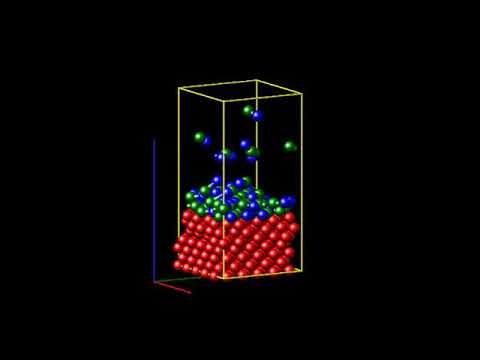

In [3]:
#@title Deposicion de átomos y moléculas.
YouTubeVideo('3jr02v93q_0')

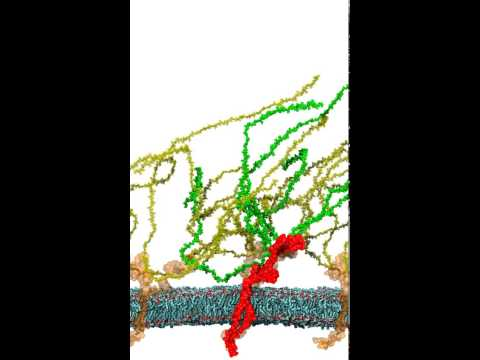

In [ ]:
#@title Efecto de un flujo sobre matriz pericelular.
YouTubeVideo('RE2s8ld8hAs')

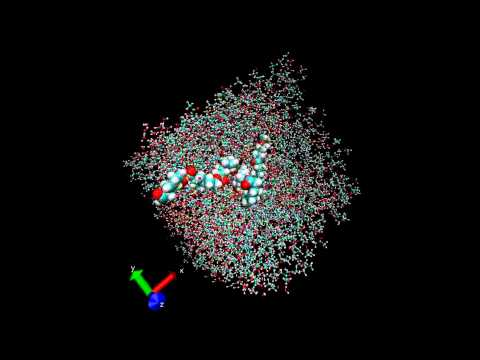

In [ ]:
#@title Polímero en agua y solvente.
YouTubeVideo('_rBalorrv_c')

##Dinámica molecular

La dinámica molecular es una técnica de **simulación computacional** que modela el comportamiento de partículas (átomos, moléculas, iones) mediante la solución numérica de ecuaciones de movimiento y fuerza. Esta disciplina permite estudiar la **evolución temporal** y el comportamiento de sistemas a nivel atómico o molecular, proporcionando información valiosa sobre propiedades físicas y químicas, interacciones y reacciones en sistemas biológicos, materiales y otros campos científicos.

Las etapas de una dinámica molecular de forma muy sencilla son las siguientes:

1. <ins>Preparación del sistema</ins>: Se define el sistema a estudiar, que puede ser una molécula, proteína, material, etc. Se establecen las **condiciones iniciales**, como posiciones y velocidades de las partículas.

2. <ins>Asignación de fuerzas</ins>: Se definen las **interacciones** entre las partículas mediante modelos matemáticos y potenciales de fuerza, que representan las interacciones atractivas y repulsivas entre átomos o moléculas.


3. <ins>Simulación</ins>: Se ejecuta la simulación, donde se van calculando las **trayectorias** de las partículas a lo largo del tiempo, avanzando paso a paso.

4. <ins>Análisis de resultados</ins>: Una vez finalizada la simulación, se **analizan los datos** obtenidos para extraer información relevante sobre el sistema, como estructuras, propiedades termodinámicas, dinámica y comportamiento molecular.





---



# **2 Manos a la obra.**



##2.1 Abrimos LAMMPS

In [ ]:
from lammps import lammps
import math
L = lammps()

##2.2 Iniciamos la simulación

In [ ]:
L.command("units         metal")
L.command("atom_style    atomic")
L.command("dimension     3")
L.command("boundary      f f f")
L.command("region        forbox block 0 50 0 50 0 50 units box")
L.command("region        for1 block 15 35 15 35 15 35 units box")
L.command("create_box    1 forbox")
# --------Argón (Ar)---------
L.command("lattice       fcc 4.58")
L.command("create_atoms  1 region for1")
L.command("mass          1 39.948")
L.command("pair_style    lj/cut 12")
L.command("pair_coeff    1 1 0.0102383 3.405 12")
# ---------------------------
L.command("neighbor      3.0 bin")
L.command("neigh_modify  delay 10 check yes")
L.command("group         ar type 1")
L.command("minimize      1e-7 1e-9 10000 10000")
L.command("dump          dump_init ar xyz 1 traj_init.xyz ")
L.command("run           0")
L.command("undump         dump_init")
print(    "Configuracion inicial preparada y lista")

Configuracion inicial preparada y lista


###Configuración inicial e interacciones.


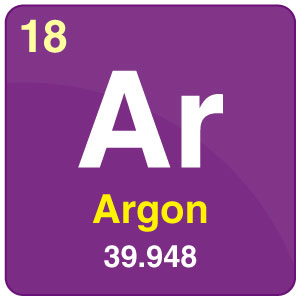

In [ ]:
#@title Argón (Ar)
url="https://cdn1.byjus.com/wp-content/uploads/2018/07/Argon-1.jpg"
Disp.Image(requests.get(url).content, width=250, height=250)

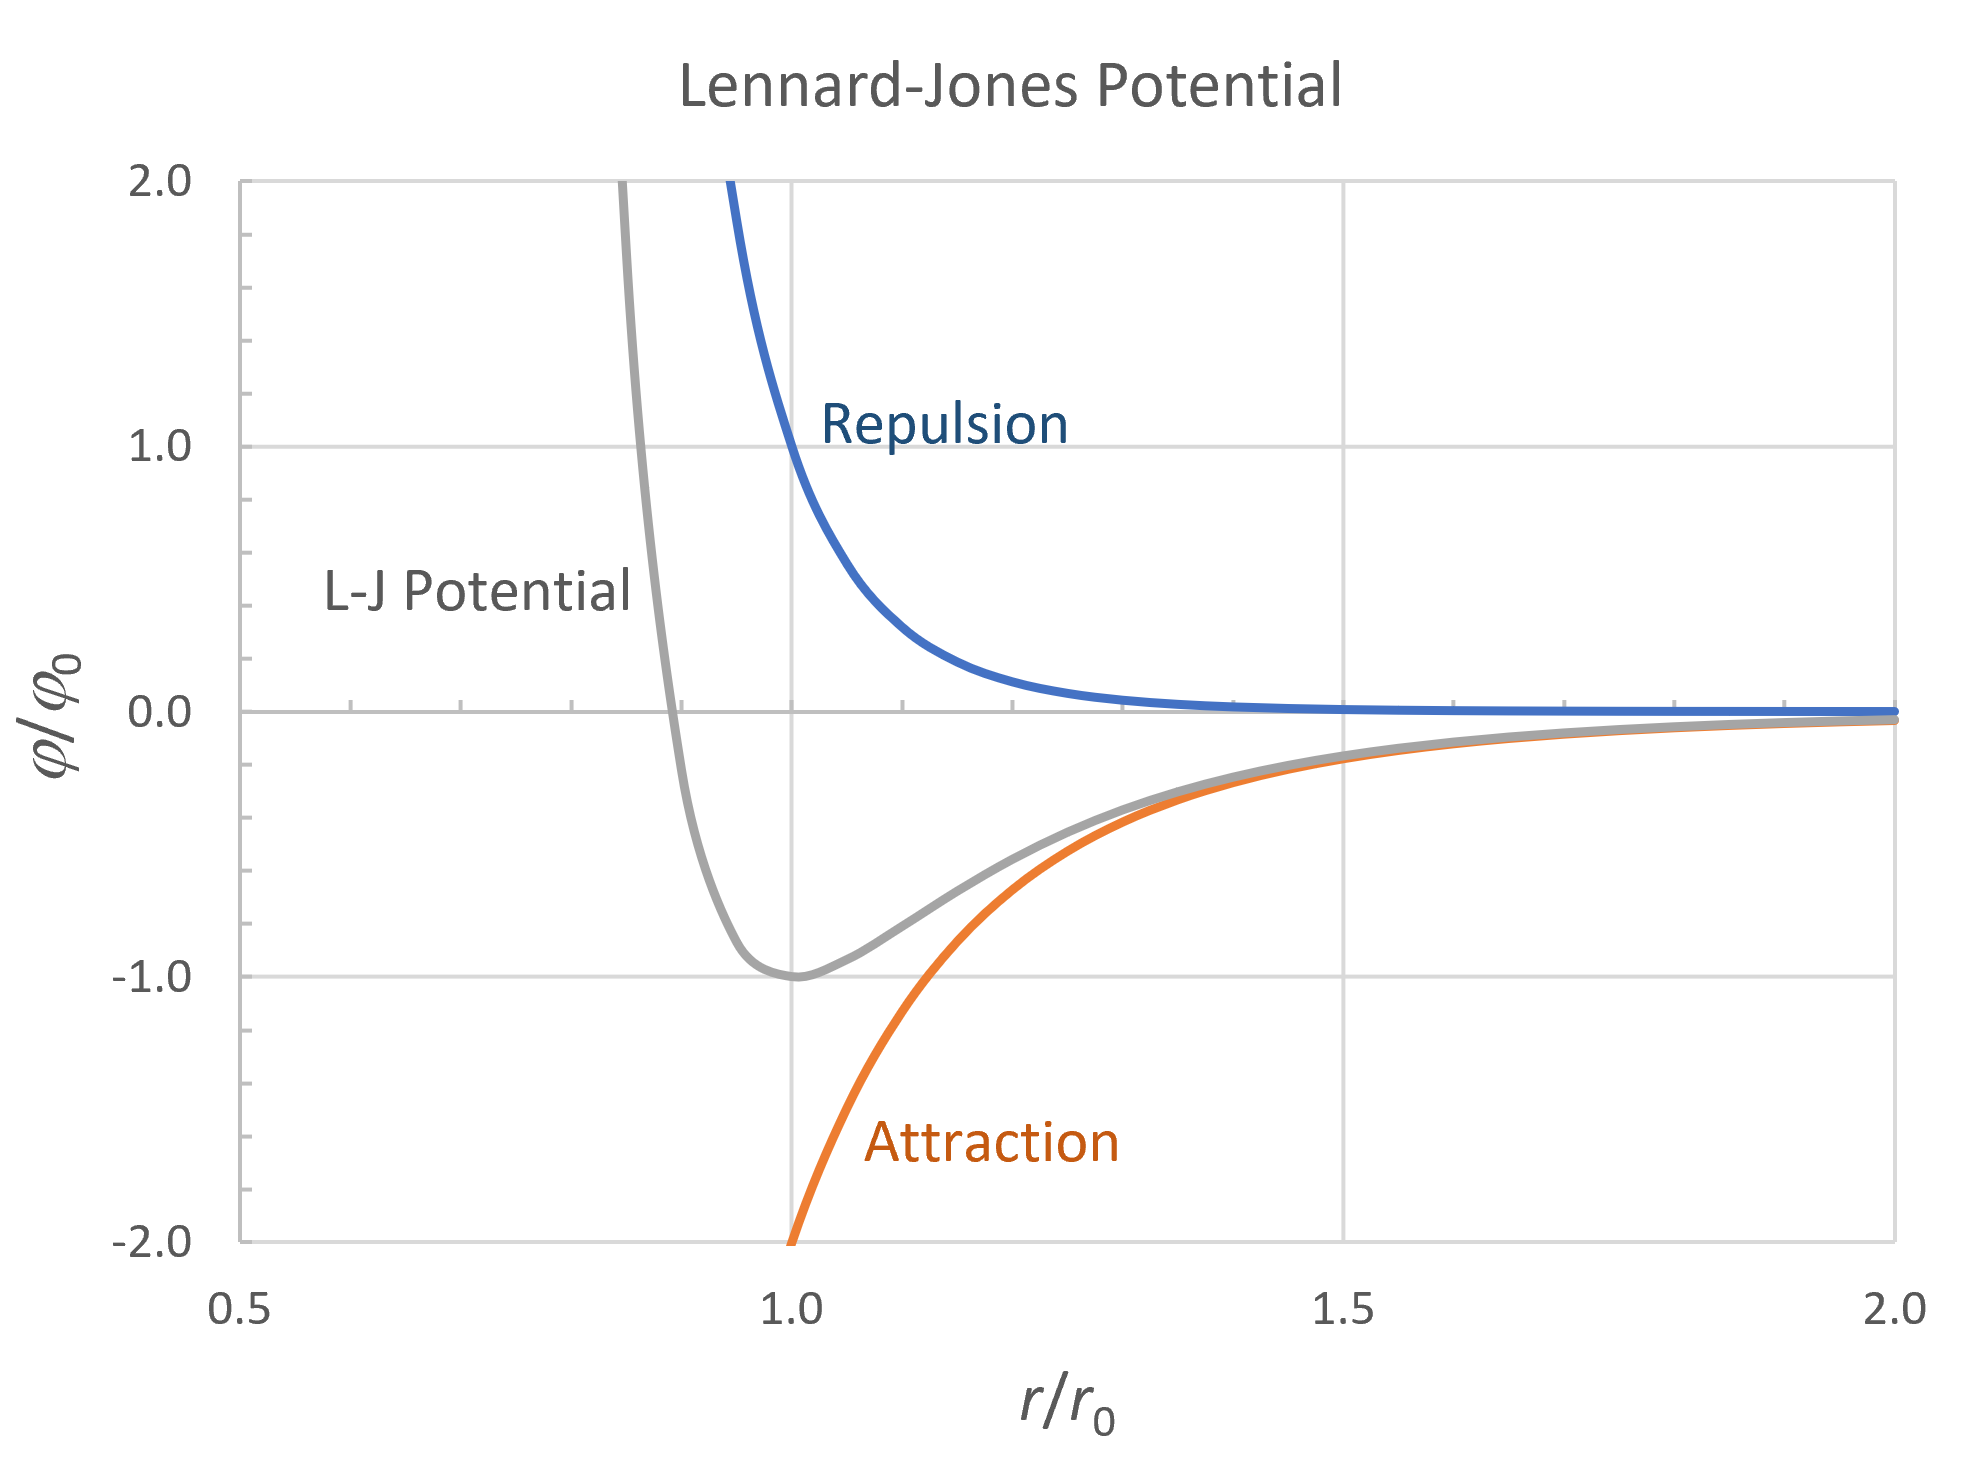

In [ ]:
#@title Potencial de interaccion (LJ)
url="https://polymerdatabase.com/polymer%20physics/images/LJP.png"
Disp.Image(requests.get(url).content, width=350, height=250)

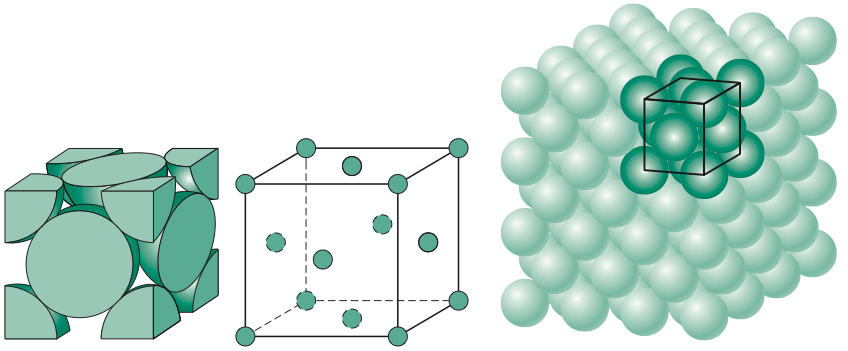

In [ ]:
#@title Arreglo Cubico Centrado en las Caras (FCC)
url="https://www.e-education.psu.edu/matse81/sites/www.e-education.psu.edu.matse81/files/images/lesson05/FCC.png"
Disp.Image(requests.get(url).content, width=500, height=250)

In [ ]:
_natoms, _nsteps, _xyzs = read_xyz_traj(filename='traj_init.xyz')

viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df)

##2.3 Dinámica para equilibrar a una temperatura de ~1K

In [ ]:
L.command("log log_read.lammps")
L.command("timestep      0.01")
#-------------Asignación de temperatura (K)--------------
L.command("velocity      ar create 1 102939 dist gaussian mom yes rot yes")
#---------------------------------------------------------
L.command("fix           1 ar nve")
L.command("thermo_style  custom step temp etotal press vol density")
L.command("thermo        10")
L.command("dump          dump_0 ar xyz 50 traj_tcte.xyz ")
L.command("run 1000")
L.command("unfix         1")
L.command("undump        dump_0")

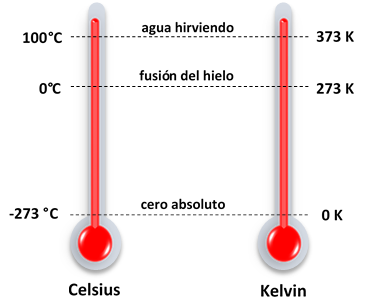

In [ ]:
#@title Escala Kelvin
url="https://rinconeducativo.org/wp-content/uploads/2020/08/celsius-y-kelvin.png"
Disp.Image(requests.get(url).content)

In [ ]:
#plot temperatura vs timestep y ponerle el titulo y nombre a los ejes
log_data = ReadLog('log_read.lammps')
temp = log_data.get('Temp')
timestep = log_data.get("Step")
plt.plot(timestep, temp,c='r')
plt.xlabel("Paso de tiempo")
plt.ylabel("Temperatura")

In [ ]:
_natoms, _nsteps, _xyzs = read_xyz_traj(filename='traj_tcte.xyz')

viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df)

##2.4 Dinámica calentando el sistema hasta 300 K

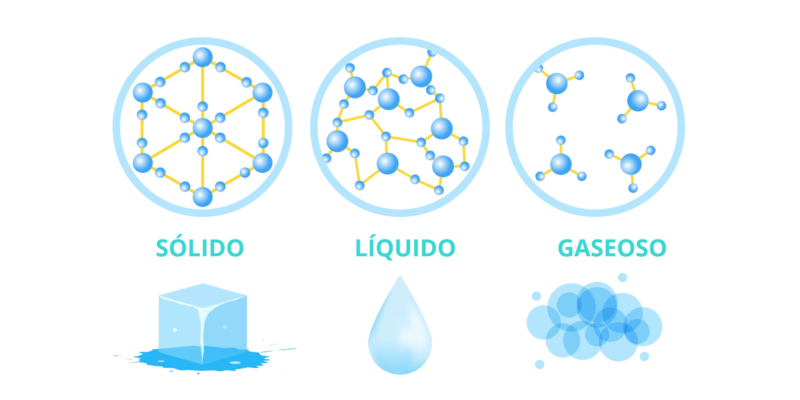

In [ ]:
#@title Estados de la Materia
url="https://humanidades.com/wp-content/uploads/2018/12/estados-de-la-materia-1-e1585163452419.png"
Disp.Image(requests.get(url).content, width=500, height=350)
#Hablar sobre fase solida, liquida y gaseosa, analogia con el agua.

In [ ]:
L.command("dump          dump_1 ar xyz 80 traj_heating.xyz ")
L.command("variable      t1 equal temp")
L.command("fix           r  ar wall/reflect xlo 0.0 xhi 50 ylo 0.0 yhi 50 zlo 0.0 zhi 50 units box")
#-------------Simulación rampa de temperatura (K)--------------
L.command("fix           2 ar nvt temp ${t1} 300 10")
#--------------------------------------------------------------
L.command("run 30000")
L.command("unfix         2")
L.command("undump        dump_1")

In [ ]:
#plot temperatura vs timestep y ponerle el titulo y nombre a los ejes
log_data = ReadLog('log_read.lammps')
temp = log_data.get('Temp')
timestep = log_data.get("Step")
plt.plot(timestep, temp,c='r')
plt.xlabel("Paso de tiempo")
plt.ylabel("Temperatura")

In [ ]:
_natoms, _nsteps, _xyzs = read_xyz_traj(filename='traj_heating.xyz')

viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df)

##2.5 Dinámica enfriando el sistema hasta 0.0001 K

In [ ]:
L.command("dump          dump_2 ar xyz 100 traj_cooling.xyz ")
L.command("variable      t2 equal temp")
#-------------Simulación rampa de temperatura (K)--------------
L.command("fix           3 ar nvt temp ${t2} 0.0001 5")
#--------------------------------------------------------------
L.command("run           30000")
L.command("unfix         3")
L.command("fix           4 ar nve")
L.command("run           10000")
L.command("unfix         4")
L.command("undump        dump_2")
L.close()

In [ ]:
#plot temperatura vs timestep y ponerle el titulo y nombre a los ejes
log_data = ReadLog('log_read.lammps')
temp = log_data.get('Temp')
timestep = log_data.get("Step")
plt.plot(timestep, temp,c='r')
plt.xlabel("Paso de tiempo")
plt.ylabel("Temperatura")

In [ ]:
_natoms, _nsteps, _xyzs = read_xyz_traj(filename='traj_cooling.xyz')

viz_xyz_traj(_natoms, _nsteps, _xyzs, mass_df)

##3 Preguntas

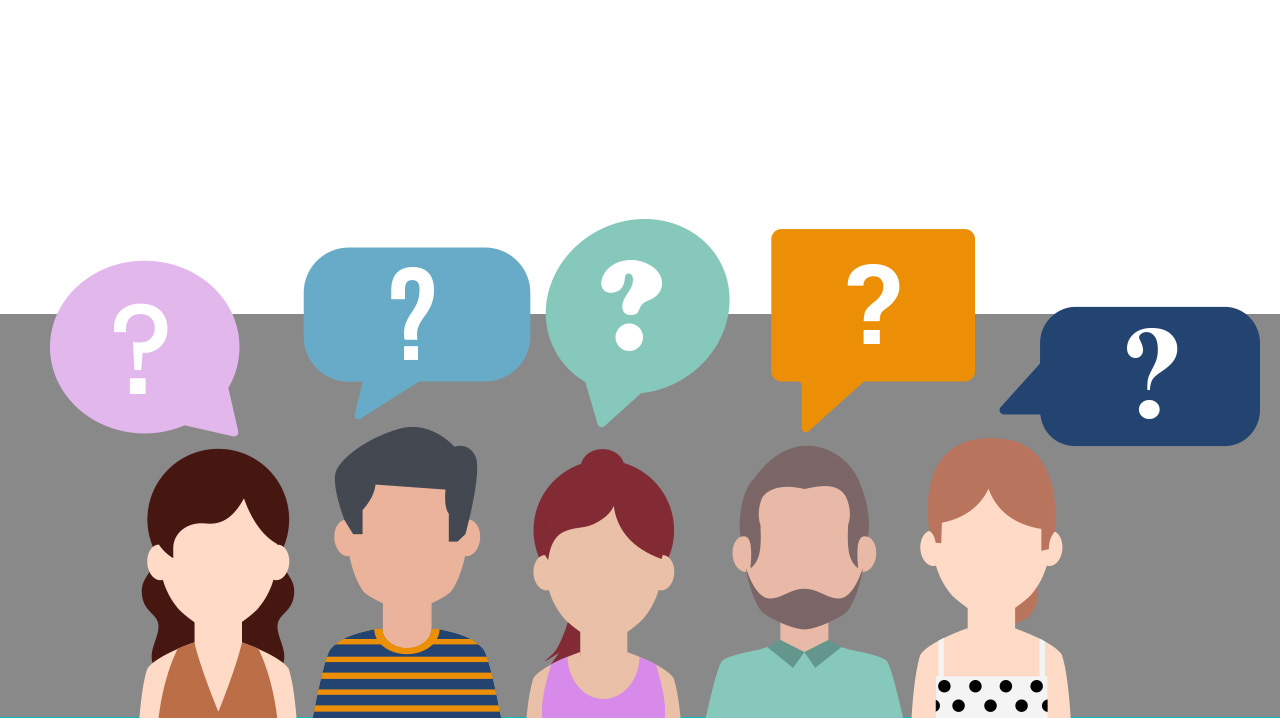

In [ ]:
#@title ???
url="https://orquideatech.com/wp-content/uploads/2019/07/7-preguntas-que-debes-hacer-en-tus-registros.jpg"
Disp.Image(requests.get(url).content, width=500, height=350)
#Hablar sobre fase solida, liquida y gaseosa, analogia con el agua.



---
Mi correo: jmartinhumoller@unc.edu.ar

Fuente del INPUT de LAMMPS  [Link](https://www.youtube.com/watch?v=lBYanQRnMA8&t=22s)
